In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('./hockenberry.mplstyle')
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

import statsmodels.formula.api as smf
import seaborn as sns

# Defining constants and save directories

The `sparse_data` flag refers to whether I want to use the "full" dataset of gene expression conditions (n = 103) or a more sparsely populated / thinned down dataset containing less redundancy (n=30, where there less underlying structure between the conditions).

In [3]:
import datetime
import os

year = datetime.date.today().year
month = datetime.date.today().month
base_figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(base_figs_dir):
    os.makedirs(base_figs_dir)

In [176]:
# data_tag = 'ecoli_full'
data_tag = 'ecoli_sparse'
# data_tag = 'scer_rna'
# data_tag = 'scer_prot'
save_figs = True

if save_figs:
    figs_dir = base_figs_dir+'/{}'.format(data_tag)
    if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)

# Read in the data

In [177]:
if data_tag == 'ecoli_full':
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata.tsv', sep='\t', index_col=0)
elif data_tag == 'ecoli_sparse':
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata_SPARSE.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_rna':
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata_scer_RNA.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_prot':
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata_scer_PROTEIN.tsv', sep='\t', index_col=0)
else:
    raise Exception('Incorrect organism identifier')
    
print(meta_df.shape)
meta_df.head()

(30, 27)


,Sample ID,Study,Project ID,Condition ID,Strain Description,Strain,Base Media,Carbon Source (g/L),Nitrogen Source (g/L),Electron Acceptor,...,Additional Details,DOI,GEO,Simple_sample_id,Temperature (C),pH,Growth Rate (1/hr),Alignment,Replicate #,Doubling_time
59,omics__bw_glc__1,Omics,omics,bw_glc,Escherichia coli BW25113,BW25113,M9,glucose(5),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms13091,GSE59759,omics__bw_glc,37,7.0,0.6075,97.875,2,1.140983
83,cra_crp__wt_fru__1,Cra/Crp,cra_crp,wt_fru,Escherichia coli K-12 MG1655,MG1655,M9,fructose(2),NH4Cl(1),O2,...,NaN,doi.org/10.1093/nar/gky069,GSE65643,cra_crp__wt_fru,37,7.0,0.5300,97.680,2,1.307825
97,rpoB__rpoBE546V_lb__1,RpoB Knock-in,rpoB,rpoBE546V_lb,Escherichia coli K-12 MG1655 rpoBE546V,MG1655,LB,NaN,NaN,O2,...,NaN,doi.org/10.1016/j.cels.2016.04.003,GSE59377,rpoB__rpoBE546V_lb,37,7.0,1.3400,98.575,2,0.517274
131,42c__wt_42c__1,42C Evolution,42c,wt_42c,Escherichia coli K-12 MG1655,MG1655,M9,glucose(4),NH4Cl(1),O2,...,NaN,doi.org/10.1093/molbev/msu209,GSE132442,42c__wt_42c,42,7.0,0.8200,98.370,1,0.845301
132,42c__42c_ale1__1,42C Evolution,42c,42c_ale1,Escherichia coli 42C.1.124.1,MG1655,M9,glucose(4),NH4Cl(1),O2,...,42C A1 F124 I1,doi.org/10.1093/molbev/msu209,GSE132442,42c__42c_ale1,42,7.0,0.9500,98.400,1,0.729629


In [178]:
if data_tag == 'ecoli_full':
    exp_df = pd.read_csv('../Data/processed_data/processed_expression.tsv', sep='\t', index_col=0)
elif data_tag == 'ecoli_sparse':
    exp_df = pd.read_csv('../Data/processed_data/processed_expression_SPARSE.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_rna':
    exp_df = pd.read_csv('../Data/processed_data/processed_expression_scer_RNA.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_prot':
    exp_df = pd.read_csv('../Data/processed_data/processed_expression_scer_PROTEIN.tsv', sep='\t', index_col=0)
else:
    raise Exception('Incorrect organism identifier')
    
print(exp_df.shape)
exp_df.head()

(3923, 30)


,omics__bw_glc,cra_crp__wt_fru,rpoB__rpoBE546V_lb,42c__wt_42c,42c__42c_ale1,42c__42c_ale10,ssw__wt_ac,ssw__wt_glc,ssw__wt_glyc,ssw__wt_xyl,...,ica__bw_delpurR_cytd,ytf__delyiaJ,ytf__delybiH,fps__fps_serB_ale4,pal__lyx_ale2_f6,pal__5drib_ale10,pal__tartr_ale26_f10,pal__tartr_ale28,efeU__menFentC_ale29,efeU__menFentCubiC_ale38
log-TPM,,,,,,,,,,,,,,,,,,,,,
b0002,10.213469,11.198040,8.163975,11.499706,9.341696,10.936601,7.049774,10.445776,7.678018,12.116177,...,11.355471,10.108921,10.997329,9.637229,9.627287,8.433396,7.907166,8.134838,10.273946,11.524586
b0003,9.643784,10.182029,8.127386,10.770397,8.807134,10.873113,7.265206,9.787075,8.384440,11.883905,...,10.689982,9.369616,10.346011,9.083919,9.250534,8.298816,8.026256,7.992993,10.138576,10.694248
b0004,9.876957,10.037740,8.065428,10.785005,8.996823,10.356236,7.371951,9.916621,8.745754,11.992770,...,10.989716,9.355340,10.279033,9.234281,9.203814,8.550062,8.090676,8.173352,10.454710,10.977106
b0005,5.909349,6.058802,3.848184,5.455772,4.749646,6.105699,3.707233,4.968974,5.925175,7.244506,...,6.164810,4.639188,5.451973,6.195112,4.807384,4.677902,3.684667,4.050593,5.842332,5.841291
b0006,6.876792,6.555468,6.963816,7.316602,6.658317,6.848067,6.595414,6.996502,6.186970,5.285927,...,7.199466,6.713470,6.748590,7.503775,6.398236,6.546094,6.635715,6.675508,8.346839,8.081482


In [179]:
if data_tag == 'ecoli_full':
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary.tsv', sep='\t', index_col=0)
elif data_tag == 'ecoli_sparse':
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary_SPARSE.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_rna':
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary_scer_RNA.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_prot':
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary_scer_PROTEIN.tsv', sep='\t', index_col=0)
else:
    raise Exception('Incorrect organism identifier')
    
print(exp_summary_df.shape)
exp_summary_df.head()

(3923, 13)


,count,mean,std,min,25_percentile,50_percentile,75_percentile,max,cv,noise,lin_slope,lin_r,spearmans_rho
log-TPM,,,,,,,,,,,,,
b0002,30.0,9.793315,1.444897,7.049774,8.396229,10.072792,10.968085,12.116177,0.147539,0.021768,0.044448,0.220242,0.281010
b0003,30.0,9.430157,1.206869,7.265206,8.320222,9.506700,10.306421,11.883905,0.127980,0.016379,0.055293,0.228843,0.321949
b0004,30.0,9.512561,1.185379,7.371951,8.598985,9.426478,10.336935,11.992770,0.124612,0.015528,0.053242,0.216430,0.287685
b0005,30.0,5.293082,1.020252,3.161854,4.681027,5.412823,6.025395,7.244506,0.192752,0.037153,0.077310,0.270489,0.348871
b0006,30.0,6.814419,0.593300,5.285927,6.554015,6.694489,7.086320,8.346839,0.087065,0.007580,0.141197,0.287281,0.355323


# Explore the relationship between conditions

In [180]:
cond_corr_mat = exp_df.corr(method='pearson')
cond_corr_mat.head()

,omics__bw_glc,cra_crp__wt_fru,rpoB__rpoBE546V_lb,42c__wt_42c,42c__42c_ale1,42c__42c_ale10,ssw__wt_ac,ssw__wt_glc,ssw__wt_glyc,ssw__wt_xyl,...,ica__bw_delpurR_cytd,ytf__delyiaJ,ytf__delybiH,fps__fps_serB_ale4,pal__lyx_ale2_f6,pal__5drib_ale10,pal__tartr_ale26_f10,pal__tartr_ale28,efeU__menFentC_ale29,efeU__menFentCubiC_ale38
omics__bw_glc,1.000000,0.909657,0.817640,0.900450,0.813720,0.868808,0.902204,0.924771,0.825502,0.850828,...,0.891452,0.858220,0.896299,0.932245,0.879207,0.856230,0.850454,0.916311,0.846943,0.922465
cra_crp__wt_fru,0.909657,1.000000,0.877816,0.922475,0.832138,0.844429,0.879467,0.902047,0.819320,0.808435,...,0.885792,0.848266,0.883513,0.873221,0.879590,0.872495,0.847343,0.892506,0.838630,0.896035
rpoB__rpoBE546V_lb,0.817640,0.877816,1.000000,0.867305,0.771077,0.751158,0.835076,0.779117,0.798648,0.749816,...,0.782456,0.777575,0.798701,0.776773,0.826108,0.832263,0.830775,0.829617,0.796523,0.809776
42c__wt_42c,0.900450,0.922475,0.867305,1.000000,0.829046,0.840244,0.842630,0.875929,0.799581,0.808296,...,0.880632,0.866267,0.888678,0.870325,0.811984,0.820989,0.799399,0.845332,0.873343,0.919382
42c__42c_ale1,0.813720,0.832138,0.771077,0.829046,1.000000,0.924542,0.754521,0.805757,0.855802,0.827781,...,0.843499,0.863176,0.847634,0.758904,0.773238,0.789946,0.759855,0.808227,0.898806,0.813096


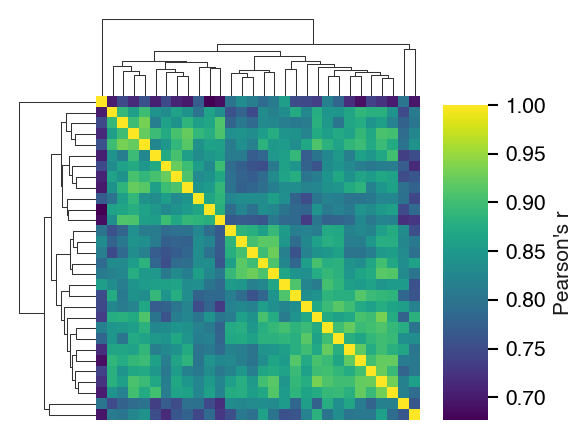

In [181]:
ax = sns.clustermap(cond_corr_mat, yticklabels=False, xticklabels=False, cmap='viridis',\
               cbar_pos=[1.0, 0.05, 0.1, 0.7], figsize=(3,3), cbar_kws={'label': r"Pearson's r"})
ax.ax_cbar.tick_params(labelsize=10)
if save_figs:
    plt.savefig(figs_dir+'/condition_corr_mat.pdf', bbox_inches='tight')

## Example scatterplots of two highly correlated conditions

In [182]:
mask = np.ones(cond_corr_mat.values.shape, dtype=bool)
np.fill_diagonal(mask, 0)
print(mask.shape)

tempy = (cond_corr_mat.values*mask).flatten()
tempy.sort()
print(tempy[-20:])

(30, 30)
[0.92247503 0.92247503 0.92255367 0.92255367 0.92338456 0.92338456
 0.92339971 0.92339971 0.92454156 0.92454156 0.92477058 0.92477058
 0.92759402 0.92759402 0.92958419 0.92958419 0.93224489 0.93224489
 0.93264143 0.93264143]


In [183]:
0.9327**2

0.86992929

In [95]:
example_index = -3
result = np.where(cond_corr_mat.values*mask == np.amax(tempy[example_index]))
print('Max', result)

Max (array([81, 82]), array([82, 81]))


In [96]:
idx_a = result[0][0]
idx_b = result[0][1]
cols = cond_corr_mat.columns
cond_corr_mat.loc[cols[idx_a]][cols[idx_b]]

0.9917321080566146

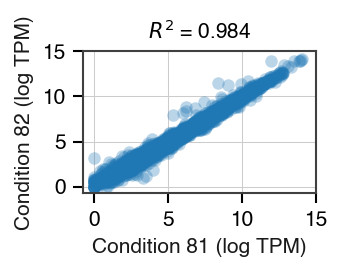

In [97]:
r, p = stats.pearsonr(exp_df[cols[idx_a]], exp_df[cols[idx_b]])
fig, ax = plt.subplots(figsize=(2.,1.25))
ax.plot(exp_df[cols[idx_a]], exp_df[cols[idx_b]], marker='o', linestyle='', alpha=0.3)
ax.set_xticks([0, 5, 10, 15])
ax.set_yticks([0, 5, 10, 15])
ax.set_xlabel('Condition {} (log TPM)'.format(idx_a))
ax.set_ylabel('Condition {} (log TPM)'.format(idx_b))
ax.set_title(r"$R^2$ = {:.3f}".format(r**2))
if save_figs:
    plt.savefig(figs_dir+'/max_condition_corr.pdf', bbox_inches='tight')

## Example scatterplots of two minimally correlated conditions

In [98]:
tempy = cond_corr_mat.values.flatten()
tempy.sort()
print(tempy[:10])

[0.64919392 0.64919392 0.65151461 0.65151461 0.67007013 0.67007013
 0.67682407 0.67682407 0.68024296 0.68024296]


In [99]:
example_index = 0
result = np.where(cond_corr_mat.values == tempy[example_index])
print('Min', result)

Min (array([44, 56]), array([56, 44]))


In [100]:
cols = cond_corr_mat.columns
idx_a = result[0][0]
idx_b = result[0][1]
cols = cond_corr_mat.columns
cond_corr_mat.loc[cols[idx_a]][cols[idx_b]]

0.6491939154909993

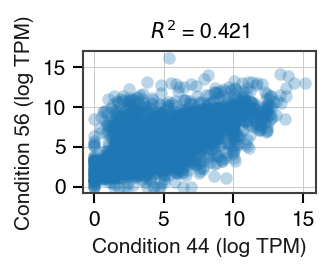

In [101]:
r, p = stats.pearsonr(exp_df[cols[idx_a]], exp_df[cols[idx_b]])
fig, ax = plt.subplots(figsize=(2.,1.25))
ax.plot(exp_df[cols[idx_a]], exp_df[cols[idx_b]], marker='o', linestyle='', alpha=0.3)
ax.set_xlabel('Condition {} (log TPM)'.format(idx_a))
ax.set_ylabel('Condition {} (log TPM)'.format(idx_b))
ax.set_title(r"$R^2$ = {:.3f}".format(r**2))
ax.set_xticks([0, 5, 10, 15])
ax.set_yticks([0, 5, 10, 15])
if save_figs:
    plt.savefig(figs_dir+'/min_condition_corr.pdf', bbox_inches='tight')

## Looking at gene expression vs various dispersion metrics

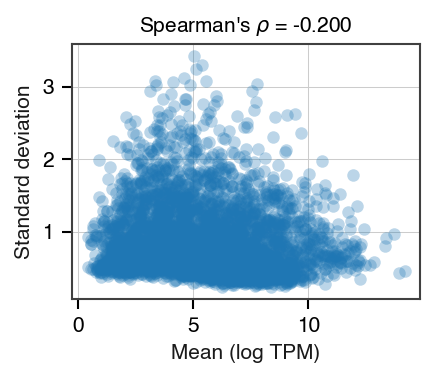

In [102]:
x_vals = exp_df.mean(axis=1)
y_vals = exp_df.std(axis=1)
rho, p = stats.spearmanr(x_vals, y_vals)
fig, ax = plt.subplots()
ax.plot(x_vals, y_vals, marker='o', linestyle='', alpha=0.3)
ax.set_xlabel('Mean (log TPM)')
ax.set_ylabel('Standard deviation')
ax.set_title(r"Spearman's $\rho$ = {:.3f}".format(rho));
if save_figs:
    plt.savefig(figs_dir+'/sdev_vs_mean.pdf', bbox_inches='tight')

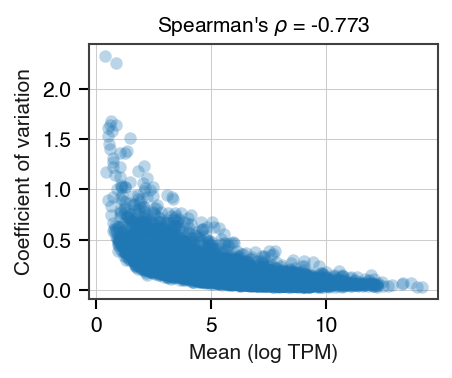

In [103]:
x_vals = exp_df.mean(axis=1)
y_vals = np.power(exp_df.std(axis=1), 1)/np.power(exp_df.mean(axis=1), 1)
rho, p = stats.spearmanr(x_vals, y_vals)
fig, ax = plt.subplots()
ax.plot(x_vals, y_vals, marker='o', linestyle='', alpha=0.3)
ax.set_xlabel('Mean (log TPM)')
ax.set_ylabel('Coefficient of variation')
ax.set_title(r"Spearman's $\rho$ = {:.3f}".format(rho));
if save_figs:
    plt.savefig(figs_dir+'/cv_vs_mean.pdf', bbox_inches='tight')

# Explore growth rate data

Slowest DT: 9.902102579427789
Fastest DT: 0.4881318172957361
Slowest rate: 0.07
Fastest rate: 1.42


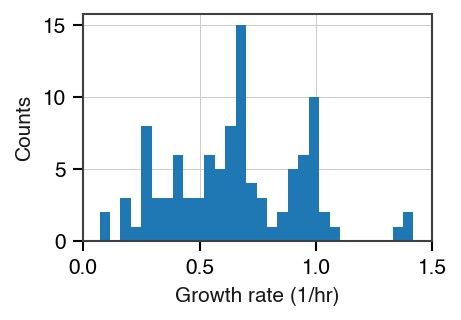

In [175]:
fig, ax = plt.subplots(figsize=(3,2))
ax.hist(meta_df['Growth Rate (1/hr)'], 30)
ax.set_xlabel('Growth rate (1/hr)')
ax.set_ylabel('Counts')
assert meta_df['Growth Rate (1/hr)'].max() < 1.5
ax.set_xlim(0, 1.5)
ax.set_title('')
if save_figs:
    plt.savefig(figs_dir+'/growth_rate_hist.pdf', bbox_inches='tight')
print('Slowest DT: {}'.format(np.log(2)/meta_df['Growth Rate (1/hr)'].min()))
print('Fastest DT: {}'.format(np.log(2)/meta_df['Growth Rate (1/hr)'].max()))
print('Slowest rate: {}'.format(meta_df['Growth Rate (1/hr)'].min()))
print('Fastest rate: {}'.format(meta_df['Growth Rate (1/hr)'].max()))

## PCA to determine the signature of growth rate variation within the expression data

In [105]:
from sklearn.decomposition import PCA, KernelPCA
from scipy.stats import zscore

In [106]:
pca = PCA(n_components=10)
pca_transform = pca.fit_transform(exp_df.T.values)
print('PCA variance:\t\t', pca.explained_variance_ratio_)

explained_variance = np.var(exp_df.values.T, axis=0)
explained_variance_ratio = np.var(pca_transform, axis=0) / np.sum(explained_variance)
print('PCA variance by hand:\t', explained_variance_ratio)
print()
print('Total PCA variance:', np.sum(explained_variance_ratio))
print()
print('PCA shape:', pca_transform.shape)
print()
print('Correlations with growth rate (PCA index, correlation results):')
r_list = []
for i in range(pca_transform.shape[1]):
    r, p = stats.pearsonr(pca_transform[:,i], meta_df['Growth Rate (1/hr)'])
    print(i, r, p)
    r_list.append(r)

PCA variance:		 [0.18996465 0.14623236 0.10336877 0.07909771 0.07000801 0.04237551
 0.02912538 0.02266744 0.0214884  0.01943199]
PCA variance by hand:	 [0.18996465 0.14623236 0.10336877 0.07909771 0.07000801 0.04237551
 0.02912538 0.02266744 0.0214884  0.01943199]

Total PCA variance: 0.723760236372889

PCA shape: (103, 10)

Correlations with growth rate (PCA index, correlation results):
0 -0.6342378879653416 6.373094060267106e-13
1 0.23382046112398108 0.01744893987299455
2 -0.02099823150271715 0.8332531436586462
3 -0.030527281257189915 0.7595221643054648
4 0.4325577213271715 5.0424352608555e-06
5 -0.174570008415733 0.07779278481719293
6 -0.018412523692055212 0.8535413907327146
7 0.06084153927997372 0.5415277536195849
8 0.0777465082389739 0.43504144612453144
9 -0.0028074954502812395 0.977546276930823


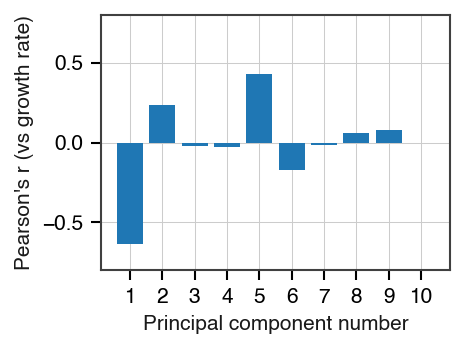

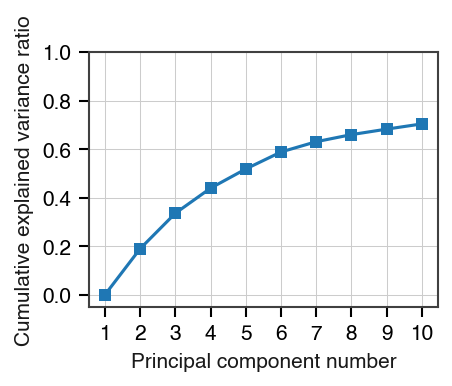

In [107]:
fig, ax = plt.subplots()
ax.bar(np.arange(1, len(r_list)+1), r_list)
ax.set_xticks(np.arange(1, len(r_list)+1))
ax.set_xlabel('Principal component number')
ax.set_ylabel(r"Pearson's r (vs growth rate)")
ax.set_ylim(-0.8, 0.8)
if save_figs:
    plt.savefig(figs_dir+'/pca_correlation.pdf', bbox_inches='tight')

cum_var = []
for i,j in enumerate(pca.explained_variance_ratio_):
    cum_var.append(np.sum(pca.explained_variance_ratio_[:i]))
fig, ax = plt.subplots()
ax.plot(np.arange(1, len(cum_var)+1), cum_var, marker='s')
ax.set_xticks(np.arange(1, len(cum_var)+1))
ax.set_xlabel('Principal component number')
ax.set_ylabel('Cumulative explained variance ratio')
ax.set_ylim(-0.05, 1.0)
if save_figs:
    plt.savefig(figs_dir+'/pca_variance.pdf', bbox_inches='tight')

## An interesting hunch / observation / side-bar using the GINI coefficient

In [108]:
def gini(x, w=None):
    x = np.asarray(x)
    if w is not None:
        w = np.asarray(w)
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        cumw = np.cumsum(sorted_w, dtype=float)
        cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) / 
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(sorted_x, dtype=float)
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

gini_vals = exp_df.apply(gini, axis=0)

SpearmanrResult(correlation=0.6978630670908461, pvalue=2.576178239973734e-16)


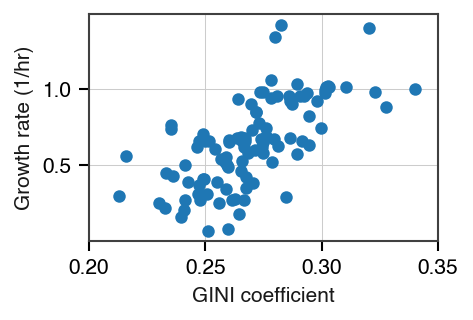

In [174]:
fig, ax = plt.subplots(figsize=(3,2))
ax.plot(gini_vals, meta_df['Growth Rate (1/hr)'], marker='o', linestyle='')
assert max(gini_vals) < 0.35
ax.set_xlim(0.2, 0.35)
ax.set_xlabel('GINI coefficient')
ax.set_ylabel('Growth rate (1/hr)')
if save_figs:
    plt.savefig(figs_dir+'/gini_vs_growth.pdf', bbox_inches='tight')

print(stats.spearmanr(gini_vals, meta_df['Growth Rate (1/hr)']))

## Assess individual gene correlations with the growth rate data

I'm only doing a single randomization/permutation here, and it should of course be noted that this randomization is a bit unfair since it destroys the underlying correlation structure between conditions. However, a permutation strategy that accounts for that structure would be very difficult and the only point here is to show that there are some genes that are more/less correlated with growth than you might expect by chance alone.

In [110]:
tempy = []
tempy_rando = []
for index in exp_df.index:
    r, p = stats.pearsonr(exp_df.loc[index], meta_df['Growth Rate (1/hr)'])
    tempy.append((index, r, p))
    r, p = stats.pearsonr(np.random.permutation(exp_df.loc[index].values), meta_df['Growth Rate (1/hr)'])
    tempy_rando.append((index, r, p))
tempy.sort(key=lambda x: x[1])
tempy_rando.sort(key=lambda x: x[1])

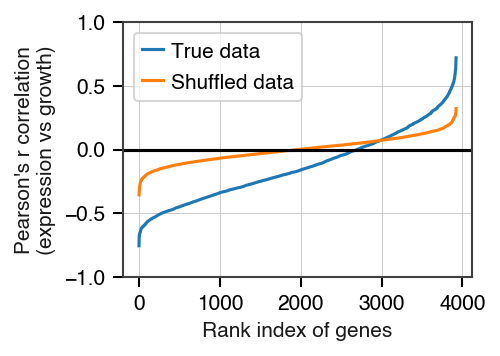

In [111]:
fig, ax = plt.subplots()
ax.plot([i[1] for i in tempy], label='True data')
ax.plot([i[1] for i in tempy_rando], label='Shuffled data')
ax.axhline(0, c='k')
ax.set_xlabel('Rank index of genes')
ax.set_ylabel('Pearson\'s r correlation\n(expression vs growth)')
plt.legend()
ax.set_ylim(-1.0, 1.0)
if save_figs:
    plt.savefig(figs_dir+'/rank_genes_growth.pdf', bbox_inches='tight')

-0.7550622608400182 0.7202138708192735


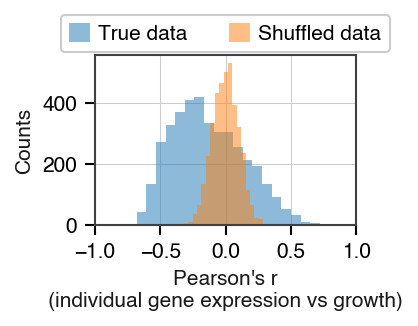

In [171]:
fig, ax = plt.subplots(figsize=(2.25,1.5))
ax.hist([i[1] for i in tempy], 20, label='True data', alpha=0.5)
ax.hist([i[1] for i in tempy_rando], 20, label='Shuffled data', alpha=0.5)
ax.set_xlabel('Pearson\'s r\n(individual gene expression vs growth)')
ax.set_ylabel('Counts')
leg = ax.legend(framealpha=1, ncol=2, loc='upper left', bbox_to_anchor=(-0.17, 1.3))
ax.set_xlim(-1.0, 1.0)
if save_figs:
    plt.savefig(figs_dir+'/hist_genes_growth.pdf', bbox_inches='tight')
print(np.min([i[1] for i in tempy]), np.max([i[1] for i in tempy]))

## Finding representative examples of genes

b4658_2 3.06439444395583
b4658_1 3.7028492557703894
b1533 5.664388499259191
b2538 4.9514232943572605
b1985 3.936318100587961
b1259 2.488104187235281
b0953 9.436766861121992
b3073 7.080314209979955
b1607 4.750192150841198
b1489 3.934471462396405


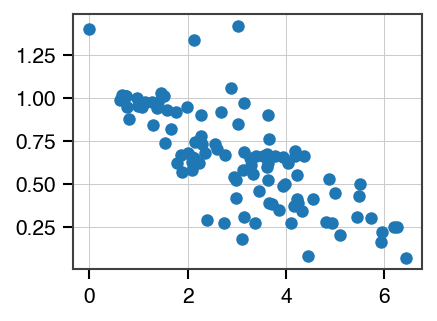

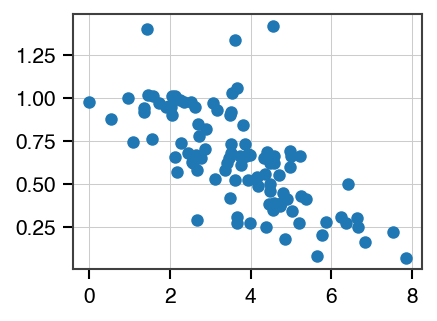

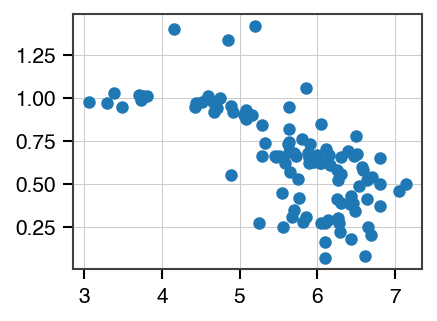

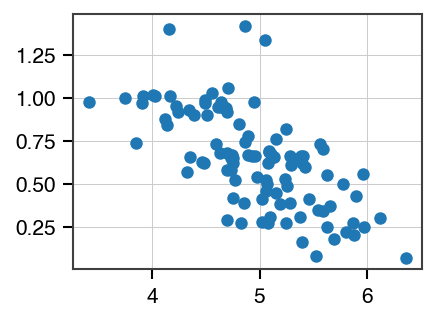

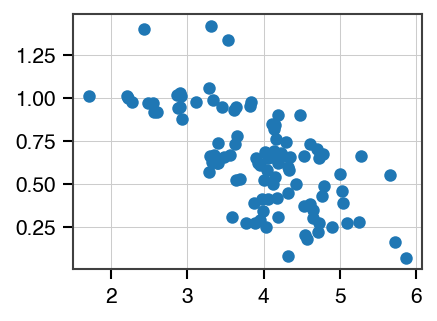

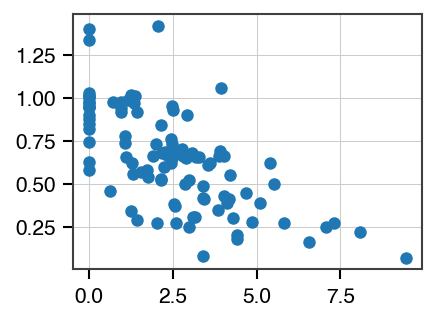

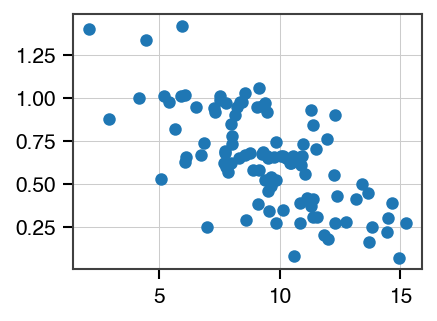

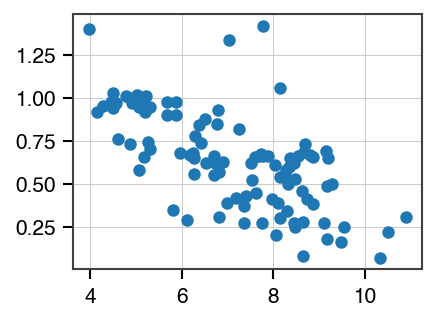

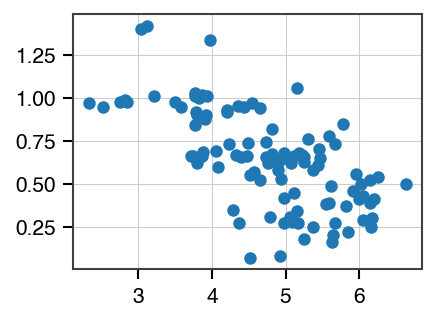

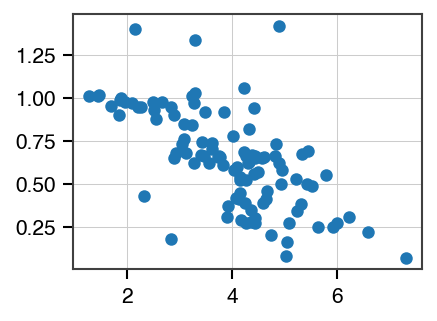

In [113]:
for i in tempy[:10]:
    fig, ax = plt.subplots()
    ax.plot(exp_df.loc[i[0]], meta_df['Growth Rate (1/hr)'], marker='o', linestyle='')
    print(i[0], exp_df.loc[i[0]].mean())

b3339 14.182324082298154
b3176 8.48826991062256
b0893 9.684601779030348
b3294 11.718292971763805
b3313 11.665870349044274
b1095 9.757356018551992
b0154 8.213076960884367
b4328 6.41991565443437
b0170 10.801267964925856
b2780 9.504768951630112


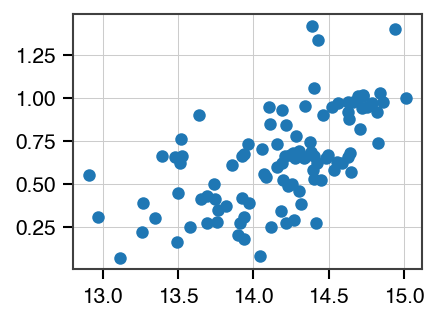

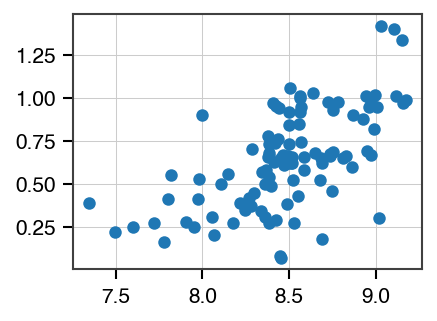

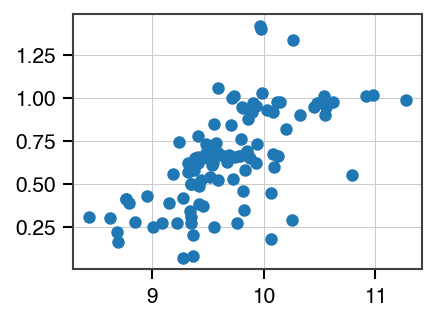

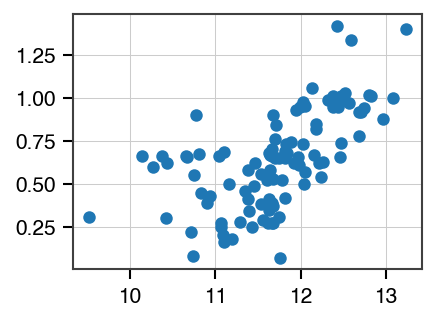

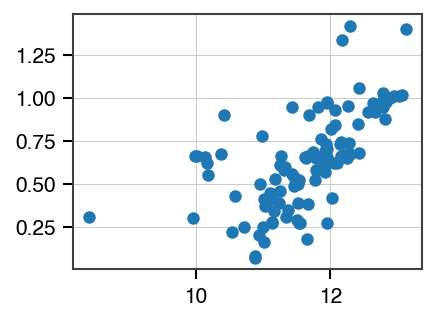

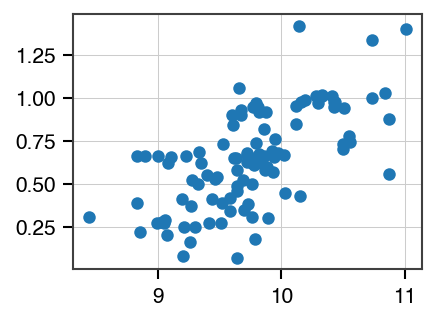

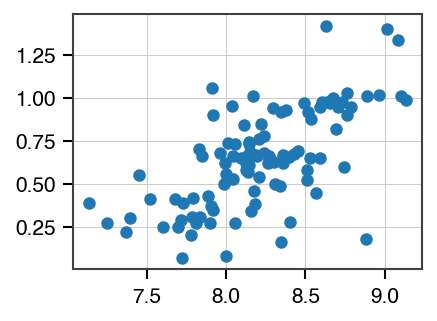

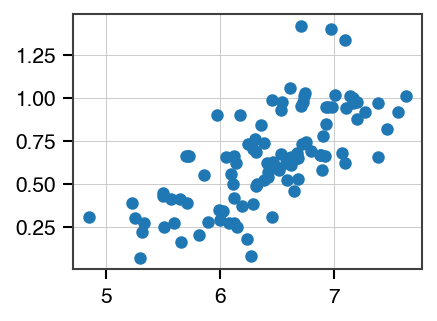

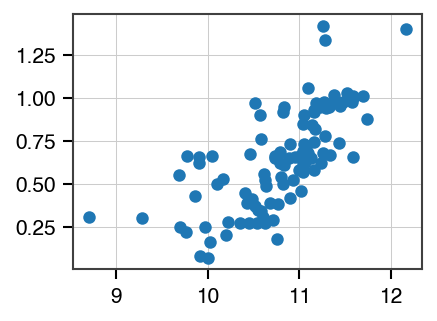

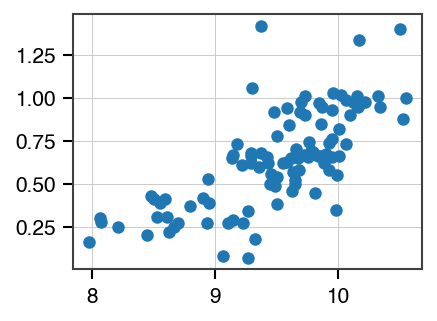

In [114]:
for i in tempy[-10:]:
    fig, ax = plt.subplots()
    ax.plot(exp_df.loc[i[0]], meta_df['Growth Rate (1/hr)'], marker='o', linestyle='')
    print(i[0], exp_df.loc[i[0]].mean())

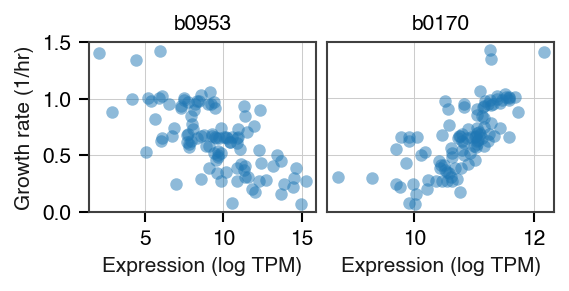

In [172]:
ltags = ['b0953', 'b0170']
fig, ax_arr = plt.subplots(figsize=(4,1.5),ncols=2, sharey=True)
ax_arr[0].plot(exp_df.loc[ltags[0]], meta_df['Growth Rate (1/hr)'], marker='o', linestyle='', alpha=0.5)
ax_arr[0].set_title(ltags[0]);
ax_arr[0].set_xlabel('Expression (log TPM)');
ax_arr[0].set_ylabel('Growth rate (1/hr)');

ax_arr[1].plot(exp_df.loc[ltags[1]], meta_df['Growth Rate (1/hr)'], marker='o', linestyle='', alpha=0.5)
ax_arr[1].set_title(ltags[1]);
ax_arr[1].set_xlabel('Expression (log TPM)');

ax_arr[0].set_yticks([0, 0.5, 1, 1.5])
plt.tick_params(axis='y', which='both', left=False)
plt.subplots_adjust(wspace=0.05)
if save_figs:
    plt.savefig(figs_dir+'/example_genes_with_growth.pdf', bbox_inches='tight')

# Expression vs growth correlation

In [62]:
fitted = smf.ols('mean ~ lin_r', data=exp_summary_df).fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     44.82
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           2.56e-11
Time:                        12:53:14   Log-Likelihood:                -4007.8
No. Observations:                3127   AIC:                             8020.
Df Residuals:                    3125   BIC:                             8032.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.5521      0.016   -547.885      0.000      -8.583      -8.521
lin_r          0.1747      0.026      6.694      0.000       0.124       0.226
==============================================================================
Omnibus:                      205.083   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              245.419
Skew:                           0.669   Prob(JB):                     5.10e-54
Kurtosis:                       3.304   Cond. No.                         1.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

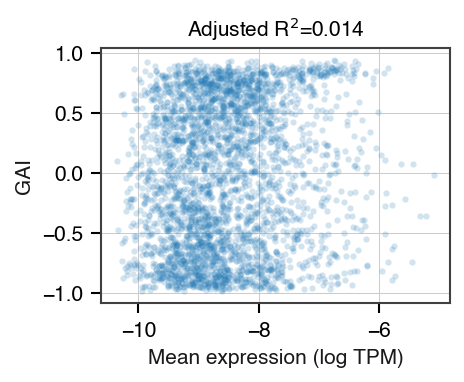

In [63]:
fig, ax = plt.subplots()
ax.plot(exp_summary_df['mean'], exp_summary_df['lin_r'], marker='.', linestyle='', alpha=0.2)
ax.set_xlabel('Mean expression (log TPM)')
ax.set_ylabel('GAI')
ax.set_title(r'Adjusted R$^2$={:.3f}'.format(fitted.rsquared_adj))
if save_figs:
    plt.savefig(figs_dir+'/mean_vs_GAI.pdf', bbox_inches='tight')